Import Necessary Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


Load and Preprocess Data

In [5]:
def load_data():
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    return train, test

train_df, test_df = load_data()

# Handling Missing Values
def handle_missing_values(dataframe):
    imputer = SimpleImputer(strategy='median')
    dataframe['Age'] = imputer.fit_transform(dataframe[['Age']])
    dataframe['Fare'] = imputer.fit_transform(dataframe[['Fare']])
    dataframe['Embarked'].fillna(dataframe['Embarked'].mode()[0], inplace=True)
    if 'Cabin' in dataframe.columns:
        dataframe.drop('Cabin', axis=1, inplace=True)
    return dataframe

train_df = handle_missing_values(train_df)
test_df = handle_missing_values(test_df)

# Encoding Categorical Variables
def encode_categorical(dataframe):
    dataframe['Sex'] = dataframe['Sex'].map({'male': 0, 'female': 1})
    dataframe = pd.get_dummies(dataframe, columns=['Embarked'], drop_first=True)
    return dataframe

train_df = encode_categorical(train_df)
test_df = encode_categorical(test_df)


Feature Engineering

In [6]:
def generate_features(dataframe):
    dataframe['FamilySize'] = dataframe['SibSp'] + dataframe['Parch'] + 1
    dataframe['IsAlone'] = 1
    dataframe['IsAlone'].loc[dataframe['FamilySize'] > 1] = 0
    dataframe['Title'] = dataframe['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    dataframe['Title'] = dataframe['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr',
                                                     'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataframe['Title'] = dataframe['Title'].replace('Mlle', 'Miss')
    dataframe['Title'] = dataframe['Title'].replace('Ms', 'Miss')
    dataframe['Title'] = dataframe['Title'].replace('Mme', 'Mrs')
    dataframe = pd.get_dummies(dataframe, columns=['Title'], drop_first=True)
    return dataframe

train_df = generate_features(train_df)
test_df = generate_features(test_df)

# Scaling Numerical Features
def scale_numerical(train_df, test_df):
    scaler = StandardScaler()
    numerical_cols = ['Age', 'Fare', 'FamilySize']
    train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
    test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])
    return train_df, test_df

train_df, test_df = scale_numerical(train_df, test_df)


Feature Selection

In [7]:
# Drop columns not needed for modeling
def drop_columns(dataframe):
    return dataframe.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

train_df = drop_columns(train_df)
test_df = drop_columns(test_df)


Train-Test Split

In [8]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


Dimensionality Reduction: PCA, LDA, t-SNE

In [9]:
# PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
print(f'Explained Variance Ratio (PCA): {pca.explained_variance_ratio_}')

# LDA
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_valid_lda = lda.transform(X_valid)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)
X_valid_tsne = tsne.fit_transform(X_valid)


Explained Variance Ratio (PCA): [0.41282569 0.21477912]


Model Training and Hyperparameter Tuning

In [10]:
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_valid_pred = rf_model.predict(X_valid)

# Evaluate model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

# Hyperparameter Tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
y_valid_pred_best = best_rf_model.predict(X_valid)
accuracy_best = accuracy_score(y_valid, y_valid_pred_best)
print(f'Best Validation Accuracy: {accuracy_best:.2f}')


Validation Accuracy: 0.83
Best Validation Accuracy: 0.82


Model Evaluation Metrics

Confusion Matrix:
 [[93 12]
 [20 54]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

ROC AUC Score: 0.91


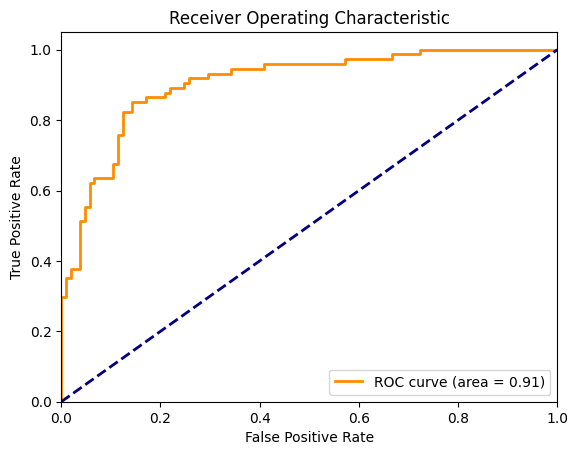

In [11]:
# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_valid, y_valid_pred_best)
class_report = classification_report(y_valid, y_valid_pred_best)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# ROC Curve and AUC Score
fpr, tpr, thresholds = roc_curve(y_valid, best_rf_model.predict_proba(X_valid)[:,1])
roc_auc = roc_auc_score(y_valid, best_rf_model.predict_proba(X_valid)[:,1])
print(f'ROC AUC Score: {roc_auc:.2f}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
